# Part I: Shift transcripts that are close to the cell wall if needed

- Push transcripts that are sitting right on the cell wall to the cytoplasm with them most gene transcripts
- Check if transcripts are clustered next to the wall and if some of those transcripts went slightly astray
- Save corrected spatial locations of cytoplasmic transcripts

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tifffile as tf
from glob import glob
import os

from scipy import ndimage
from sklearn import neighbors
from skimage import morphology

from importlib import reload
import utils

# Set directory structure

- `wsrc`: directory with 2D TIFs of cell walls
- `nsrc`: directory with 2D TIFs of cell nuclei
- `csrc`: directory with transcripts spatial location and cell metadata
- `dst`: directory to save the corrected transcript location

### Correction parameters

- We are going to evaluate for possible correction all transcripts such that
    - are within `maxdwall` pixels from a cell wall (chessboard distance)
    - Have at least `minneighs` neighbors in a `radius` pixel radius
- If more than `minprob`% of its neighbors belong to a different cell, we assume that this transcript was mislabeled and nudge it toward the cell with the most transcripts

### Setting things up

- Compute a chessboard distance transform of the cell wall
- Get individual cells through `ndimage.label`

In [4]:
struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)
theta = np.linspace(-np.pi, np.pi, 50)

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
csrc = '../data/'
dst = '../translocs/'

sample = 'A2'

radius = 30
maxdwall = 6
minneighs = 5
minprob = 74

dst += sample + os.sep
if not os.path.isdir(dst):
    os.mkdir(dst)

wall = tf.imread(wsrc + sample + '_dams_orig.tif').astype(bool)

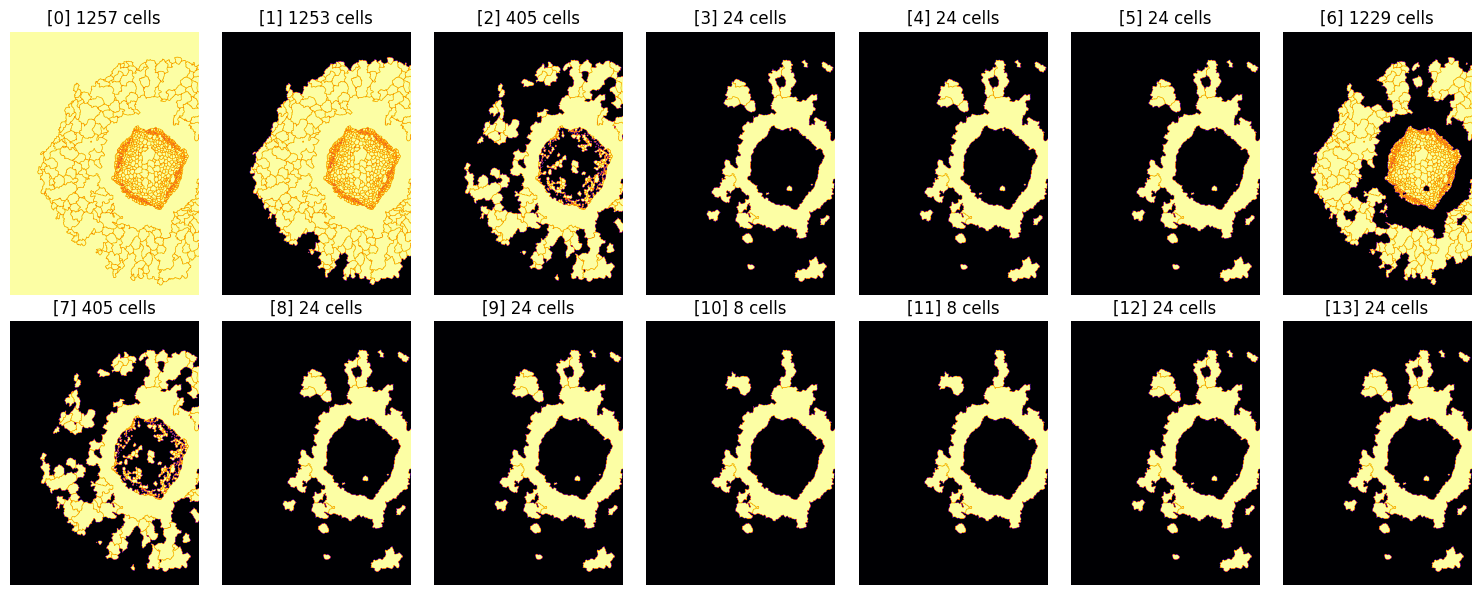

In [5]:
fig, ax = plt.subplots(2,7, sharex=True, sharey=True, figsize=(15,6))
ax = np.atleast_1d(ax).ravel()
for i in range(len(wall)):
    label, cellnum = ndimage.label(wall[i], struc1)
    ax[i].imshow(wall[i], origin='lower', cmap='inferno')
    ax[i].axis('off')
    ax[i].set_title('[{}] {} cells'.format(i, cellnum))
fig.tight_layout();

In [7]:
wall = tf.imread(wsrc + sample + '_dams_orig.tif').astype(bool)
wall = wall[0]

nzc = np.nonzero(np.all(wall, axis=0))[0]
nzr = np.nonzero(np.all(wall, axis=1))[0]

label, cellnum = ndimage.label(wall, struc1)
css = ndimage.find_objects(label)
print('Found {} cells\t'.format(cellnum), wall.shape)

Found 1257 cells	 (3001, 2144)


In [16]:
zf = 5
foo = tuple([zf*bar for bar in np.nonzero(wall)])
zcell = np.zeros((zf*wall.shape[0], zf*wall.shape[1]), dtype=np.uint8)
zcell[foo] = 255
zcell[:zf*111] = 255
zcell[2705*zf:] = 255
zcell[:, :312*zf] = 255
zcell = np.pad(zcell, ((3,0),(0,0)), constant_values=255)
zcell = ndimage.grey_dilation(zcell, size=zf+1, mode='constant')
ll, nn = ndimage.label(zcell, struc1)
print(nn, sep='\n')

1217


In [17]:
thin = ~morphology.thin(~zcell.astype(bool), max_num_iter=None)
t = 255*thin.astype(np.uint8)
ll, nn = ndimage.label(thin, struc1)
print(nn, sep='\n')

1217


In [18]:
print(zf*zf*np.sum(wall), zf*np.sum(~wall), zf*zf*wall.size, sep='\t')
print(np.sum(zcell > 0), np.sum(zcell == 0), zcell.size, sep='\t')
print(np.abs(np.sum(zcell > 0) - zf*zf*np.sum(wall)), np.abs(np.sum(zcell==0) - zf*np.sum(~wall)), zf*zf*wall.size, sep='\t')

156557600	859200	160853600
157168283	3717477	160885760
610683	2858277	160853600


In [19]:
print(zf*zf*np.sum(wall), zf*np.sum(~wall), zf*zf*wall.size, sep='\t')
print(np.sum(thin > 0), np.sum(thin == 0), zcell.size, sep='\t')
print(np.abs(np.sum(thin > 0) - zf*zf*np.sum(wall)), np.abs(np.sum(thin==0) - zf*np.sum(~wall)), zf*zf*wall.size, sep='\t')

156557600	859200	160853600
160424596	461164	160885760
3866996	398036	160853600


In [147]:
PP = 250
cidx = 150

ss = (np.s_[max([0, css[cidx][0].start - PP]) : min([wall.shape[0], css[cidx][0].stop + PP])],
      np.s_[max([0, css[cidx][1].start - PP]) : min([wall.shape[1], css[cidx][1].stop + PP])])

extent = np.array([ ss[1].start, ss[1].stop, ss[0].start, ss[0].stop ])
cell = wall[ss].copy().astype(np.uint8)
cell[ ~wall[ss]] = 0
cell[ label[ss] == cidx+1 ] = 2

cdt = ndimage.distance_transform_cdt(cell == 0, metric='chessboard')
uq, h = np.unique(label[ss], return_counts=True)
print(len(uq), sep='\n')

265


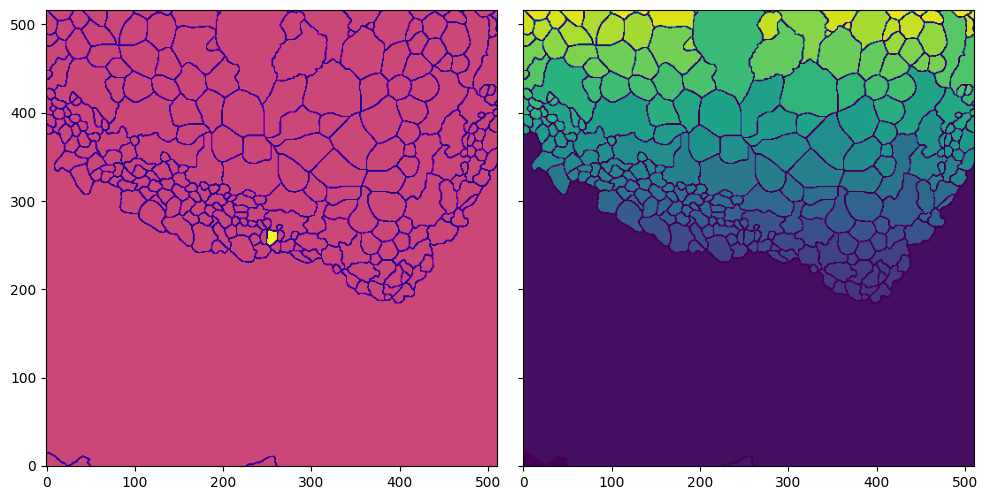

In [148]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].imshow(cell, origin='lower', cmap='plasma')
i +=1
ax[i].imshow(label[ss], origin='lower', vmin=uq[uq > 0].min()-1)
fig.tight_layout();

In [149]:
zf = 5
foo = tuple([zf*bar for bar in np.nonzero(cell != 0)])
zcell = np.zeros((zf*cell.shape[0], zf*cell.shape[1]), dtype=cell.dtype)
zcell[foo] = 2
zcell = ndimage.grey_dilation(zcell, size=zf, mode='constant')
zcdt = ndimage.distance_transform_cdt(zcell == 0, metric='chessboard')
ll, nn = ndimage.label(zcell, struc1)
np.unique(zcell)
print(nn, sep='\n')

267


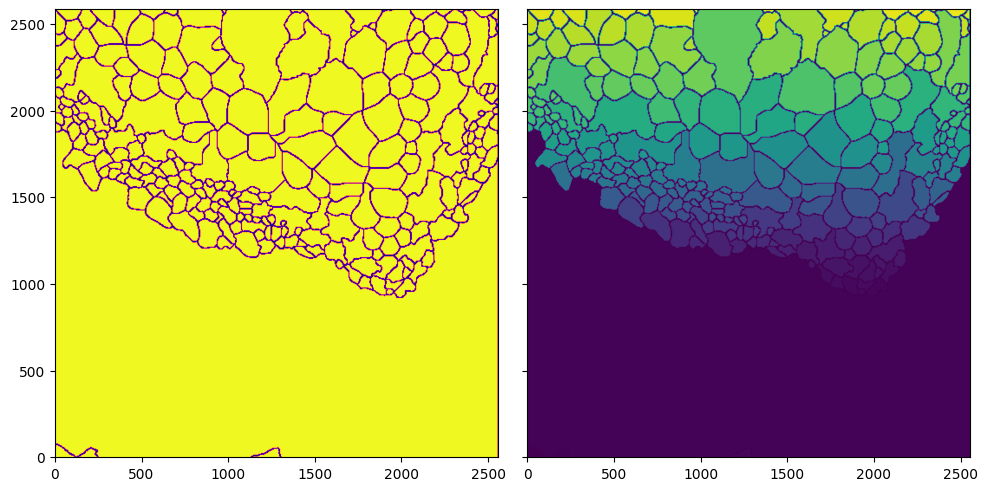

In [150]:
s_ = np.s_[250:350, :100]
fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].imshow(zcell, origin='lower', cmap='plasma')
i +=1
ax[i].imshow(ll, origin='lower')
fig.tight_layout();

In [20]:
tf.imwrite(wsrc + sample + '_dams.tif', t)

In [74]:
tf.imwrite(wsrc + sample + '_dams.tif', zcell)